# Time Series Anomaly Detection

<u>Scenario</u>: Discover anomalies in number of web pages accessed in a day by a user. Is there a bot copying the curriculum?

We will accomplish this by breaking down to the following tasks:

1. Acquire the data
1. Prepare the data
1. Make the analysis process work over all users.
    1. Compute necessary metrics to arrive at the final metric, %b (percent-b).
    1. Add user id to the dataframe that contains all the metrics, including %b.
    1. Filter to rows where %b indicates anomaly (i.e. > 1)
    1. Append rows of anomalies of new user to previous users' anomalous activity.
1. Turn the analysis process and calculations into a function that can be used to loop through for each user.
1. Test the function on a single user.
1. Analyze by looping over all users.


Finally, we will do a quick sample of exploration of the anomalies. There is much more you can do!

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import env

## Acquire

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly.

In [2]:
# gather data from codeup database
url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'

query = '''
SELECT date,
       path as endpoint,
       user_id,
       cohort_id,
       ip as source_ip
FROM logs;
'''

In [3]:
df = pd.read_sql(query, url)

In [4]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   endpoint   900222 non-null  object 
 2   user_id    900223 non-null  int64  
 3   cohort_id  847330 non-null  float64
 4   source_ip  900223 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 34.3+ MB


## Prepare

just like we would for time series analysis! 

In [6]:
# change date dtype to date dtype
df.date = df.date.astype("datetime64")

In [7]:
# reset index to be the date
df = df.set_index("date")

In [8]:
# sort index 
df = df.sort_index()

No need to split because we are not modeling, we are using statistics to identify low probability cases.

### Exponential Moving Average
Simple Moving Average (SMA) time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. For datasets that contain rapid trend shifts, a SMA may simply be too slow to be useful. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

EMA function:

 $EMA_t = \alpha *  (t_0 - EMA_{t-1}) + EMA_{t-1
}$

Where:

- t<sub>0</sub> = Latest value
- t<sub>−1</sub> = Previous value
- EMA<sub>*t−1*</sub> = Exponential moving average of previous day
- M = Number of time periods, span of the window
- $\alpha$ = multiplier = $2 \over M+1$

Instead of calculating EMA manually, we will use the pandas `ewm()` (Exponential Weighted functions) to compute our EMA. So we just need to define the following:

M = `span` argument = number of time periods. We will try 7 days, 14 days, 30 days, and 90 days.

In [11]:
# viewing endpoint column
df.endpoint

date
2018-01-26                                                   /
2018-01-26                                             java-ii
2018-01-26                 java-ii/object-oriented-programming
2018-01-26                  slides/object_oriented_programming
2018-01-26                           javascript-i/conditionals
                                    ...                       
2021-04-21                                jquery/personal-site
2021-04-21                                   jquery/mapbox-api
2021-04-21                             jquery/ajax/weather-map
2021-04-21    anomaly-detection/discrete-probabilistic-methods
2021-04-21                                   jquery/mapbox-api
Name: endpoint, Length: 900223, dtype: object

In [15]:
# group the endpoint counts for the individual days
pages = df.endpoint.resample('D').count()
pages.head()

date
2018-01-26    572
2018-01-27    230
2018-01-28    170
2018-01-29    830
2018-01-30    652
Freq: D, Name: endpoint, dtype: int64

In [13]:
# viewing endpoints over 7 days
ema_7d = pages.ewm(span=7).mean()

Notice how there are no missing values. `ewm()` will use as many values as are available to compute the mean. 

So if the span is 7 days, but there is only one day of data available (i.e. the first day), the EMA will equal the first value.

In [ ]:
# viewing endpoints over 14 days
ema_14d = pages.ewm(span=14).mean()

In [ ]:
# viewing endpoints over 30 days
ema_30d = pages.ewm(span=30).mean()

In [ ]:
# viewing endpoints over 90 days
ema_90d = pages.ewm(span=90).mean()

> Remember! These are *exponential* moving averages, not simple!

In [ ]:
# viewing the spans on a plot
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

Let's look at a smaller date range to see how these EMAs react to changes in value:

In [ ]:
# viewing the spans on a plot with the first 100 indexes
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index[:100], pages[:100], label='Daily', alpha=.5)
ax.plot(pages.index[:100], ema_7d[:100], label = '7-day EMA')
ax.plot(pages.index[:100], ema_14d[:100], label = '14-day EMA')
ax.plot(pages.index[:100], ema_30d[:100], label = '30-day EMA')
ax.plot(pages.index[:100], ema_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands

- A volatility indicator commonly used in stock market, forex, and cryptocurrency trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.
- Based on the exponential moving average

### Midband

The Exponential Moving Average

`midband = train.ewm(span=30).mean()`

### Upper & Lower Band

UB/LB = Midband +/- stdev * K

K = the number of standard deviations to go up and down from the EMA

`stdev = train.ewm(span=30).std()`

### Bandwidth

The width of the bands

Bandwidth = (UB-LB) / midband * 100

### %b, Percent Bandwidth

Shows where the last value sits in relation to the bands.

%b = last−LB / UB-LB

- If %b > 1, data point lies above the upper band
- If %b < 0, data point lies below the lower band
- If %b == .5, data point lies on the midband.

In [19]:
# set the span to 30 days and std to 3
span = 30
k = 3

In [22]:
# calculates the ewm average of the pages column with a specified span of 30 
# and returns a column representing the EWMA values.
midband = pages.ewm(span=span).mean()

In [23]:
# calculates the ewm std of the pages column with a specified span of 30 
# and returns a column representing the EWMA values.
sd = pages.ewm(span=span).std()
sd.head()

date
2018-01-26           NaN
2018-01-27    241.830519
2018-01-28    213.878138
2018-01-29    316.467837
2018-01-30    284.479727
Freq: D, Name: endpoint, dtype: float64

In [24]:
# calculating the upperband and lower band
ub = midband + sd * k
lb = midband - sd * k

In [25]:
ub.head()

date
2018-01-26            NaN
2018-01-27    1120.791557
2018-01-28     956.773991
2018-01-29    1406.405897
2018-01-30    1354.808245
Freq: D, Name: endpoint, dtype: float64

In [26]:
lb.head()

date
2018-01-26           NaN
2018-01-27   -330.191557
2018-01-28   -326.494835
2018-01-29   -492.401124
2018-01-30   -352.070116
Freq: D, Name: endpoint, dtype: float64

In [28]:
# combine the columns 
my_df = pd.concat([pages, midband, lb, ub], axis=1) 

In [29]:
# renaming columns
my_df.columns = ["pages", "midband", "lb", "ub"]

In [30]:
my_df.head()

,pages,midband,lb,ub
date,,,,
2018-01-26,572,572.000000,NaN,NaN
2018-01-27,230,395.300000,-330.191557,1120.791557
2018-01-28,170,315.139578,-326.494835,956.773991
2018-01-29,830,457.002386,-492.401124,1406.405897
2018-01-30,652,501.369064,-352.070116,1354.808245


### Plot the bands

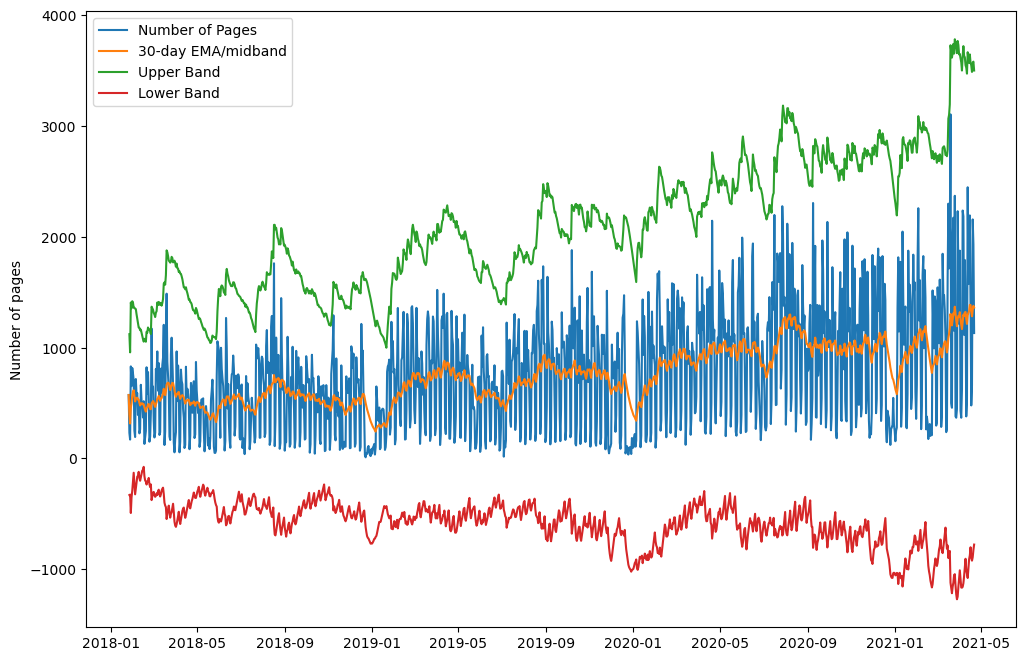

In [31]:
# plot of ub, lb and midband plotted
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Compute %b

Each data point will have a %b value that represents its relative position within/around the bollinger bands. It answers the question: Where does this point sit relative to a simple range of expected values? 

We can add a new column that shows the %b for every record in the dataset (except the first because there are no bollinger bands available for that one record)

%b = last−LB / UB-LB

In [33]:
# calculate the %b
my_df["pct_b"] = (my_df.pages - my_df.lb) / (my_df.ub - my_df.lb)

In [34]:
my_df.head()

,pages,midband,lb,ub,pct_b
date,,,,,
2018-01-26,572,572.000000,NaN,NaN,NaN
2018-01-27,230,395.300000,-330.191557,1120.791557,0.386077
2018-01-28,170,315.139578,-326.494835,956.773991,0.386899
2018-01-29,830,457.002386,-492.401124,1406.405897,0.696438
2018-01-30,652,501.369064,-352.070116,1354.808245,0.588249


Now, where do we see anomalies? We will search for %b values > 1. In this specific example, we don't need to search for values < 0 because a low extreme is not something we are concerned about. 

In [35]:
# filter for %b  greater than 1
my_df[my_df.pct_b > 1]

,pages,midband,lb,ub,pct_b
date,,,,,


No anomalies found. Remember, the cutoff is based on the arbitrary selection for K earlier. We could always pick a different K.

Anyways great! There are no anomalies! Problem solved. 

...not so fast.

During our preparation step we resampled the data to a daily period. The bollinger bands and %b are only looking for individual days where the overall aggregate log activity was extreme. If the number of users is large enough, then an individual who is scraping our data may not be extreme enough to push a single day that far from the EMA. 

We need to dig deeper. Lets look at our data on a user by user basis:

In [38]:
def acquire_logs(user=env.username, password=env.password, host=env.host):
    """Acquire curriculum logs from a MySQL database.

    Args:
        user (str, optional): The username for the MySQL database. Defaults to env.username.
        password (str, optional): The password for the MySQL database. Defaults to env.password.
        host (str, optional): The host address for the MySQL database. Defaults to env.host.

    Returns:
        pd.DataFrame: A DataFrame containing the acquired curriculum logs.

    Raises:
        ImportError: If the required libraries (pandas and pymysql) are not installed.
        OperationalError: If there is an issue connecting to the MySQL database.

    """
    url = f'mysql+pymysql://{user}:{password}@{host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    url = f'mysql+pymysql://{env.username}:{env.password}@{env.host}/curriculum_logs'
    query = '''
    SELECT date,
           path as endpoint,
           user_id,
           cohort_id,
           ip as source_ip
    FROM logs;
    '''
    df = pd.read_sql(query, url)
    return df

In [39]:
def one_user_df_prep(df, user):
    """Prepare a DataFrame for a specific user.

    Args:
        df (pd.DataFrame): The original DataFrame containing user data.
        user (str): The user ID for which the DataFrame is to be prepared.

    Returns:
        pd.Series: A Pandas Series containing the count of pages visited by the specified user per day.

    """
    df = df[df.user_id == user].copy()
    df.date = pd.to_datetime(df.date)
    df = df.set_index(df.date)
    df = df.sort_index()
    pages_one_user = df['endpoint'].resample('d').count()
    return pages_one_user

In [40]:
def compute_pct_b(pages_one_user, span, k, user):
    """Compute the percentage bandwidth (pct_b) for a given user's page data.

    Args:
        pages_one_user (pd.Series): The user's page data.
        span (int): The span parameter for the exponential weighted moving average (EWMA) calculations.
        k (float): The scaling factor to determine the upper and lower bounds.
        user (str): The ID or name of the user.

    Returns:
        pd.DataFrame: A DataFrame containing the user's page data along with the midband, upper bound (ub), 
                      lower bound (lb), and the percentage bandwidth (pct_b) for each data point.
                      
    """
    midband = pages_one_user.ewm(span=span).mean()
    stdev = pages_one_user.ewm(span=span).std()
    ub = midband + stdev*k
    lb = midband - stdev*k
    
    my_df = pd.concat([pages_one_user, midband, ub, lb], axis=1)
    my_df.columns = ['pages_one_user', 'midband', 'ub', 'lb']
    
    my_df['pct_b'] = (my_df['pages_one_user'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

In [41]:
def plot_bands(my_df, user):
    """Plot bands for number of pages against time.

    Args:
        my_df (pd.DataFrame): The DataFrame containing the data to be plotted.
        user (str): The user for which the number of pages is plotted.

    Returns:
        None

    """
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages_one_user, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

In [42]:
def find_anomalies(df, user, span, weight, plot=False):
    """Find anomalies for a specific user in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        user (str): The user for whom to find anomalies.
        span (int): The span parameter for computing percent B values.
        weight (float): The weight parameter for computing percent B values.
        plot (bool, optional): Whether to plot the bands. Defaults to False.

    Returns:
        pd.DataFrame: A DataFrame containing the anomalies for the specified user.

    """
    # Prepare DataFrame for the user
    pages_one_user = one_user_df_prep(df, user)

    # Compute percent B values
    my_df = compute_pct_b(pages_one_user, span, weight, user)

    # Plot bands if plot is True
    if plot:
        plot_bands(my_df, user)

    # Return anomalies (percent B > 1)
    return my_df[my_df.pct_b > 1]


# Using our functions:

In [43]:
# get data
df = acquire_logs()

In [44]:
df.head()

,date,endpoint,user_id,cohort_id,source_ip
0,2018-01-26,/,1,8.0,97.105.19.61
1,2018-01-26,java-ii,1,8.0,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22.0,97.105.19.61


#### Test function on a single user:

In [45]:
# variables for function
user=1
span=30

k=6

In [46]:
# anomalies for one user
find_anomalies(df, user, span, k)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,


No daily anomalies for user 1

#### Use function in a loop examining all users:

In [47]:
# anomalies for all users with std of 3.5
k = 3.5

anomalies = pd.DataFrame()
for u in df.user_id.unique():
#     print(u)
    one_user = find_anomalies(df, u, span, k)
# anomalies for one user
    anomalies = pd.concat([anomalies, one_user])

In [48]:
anomalies

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1
2018-10-15,9,0.581421,8.457414,-7.294571,1.034446,3
2019-01-09,4,0.262470,3.802115,-3.277175,1.027953,3
2019-04-06,2,0.129825,1.889712,-1.630061,1.031334,3
...,...,...,...,...,...,...
2021-01-24,7,0.574393,6.857226,-5.708440,1.011362,817
2021-03-25,59,6.824556,58.415342,-44.766230,1.005666,843
2021-02-23,67,8.229409,66.322904,-49.864086,1.005828,851


In [49]:
# anomalies for one user
find_anomalies(df, user, span, k)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-01-29,44,3.623334,42.081344,-34.834677,1.024945,1
2019-07-08,101,8.248768,96.507472,-80.009936,1.025451,1


#### Are there users that show up more frequently than others?

In [50]:
# user ids and the number of page hits for them
anomalies.user_id.value_counts()

88     12
146    11
80     11
18     10
291     9
       ..
526     1
527     1
528     1
206     1
859     1
Name: user_id, Length: 413, dtype: int64

#### Let's plot user #88:

In [51]:
# checking user 88
one_user_df_prep(df, 88)

date
2018-02-05    1
2018-02-06    0
2018-02-07    0
2018-02-08    0
2018-02-09    0
             ..
2021-01-25    0
2021-01-26    0
2021-01-27    0
2021-01-28    0
2021-01-29    3
Freq: D, Name: endpoint, Length: 1090, dtype: int64

#### Lets sort by the page counts:

In [52]:
# sorting values in decsending order based on the pages_one_user
anomalies.sort_values(by="pages_one_user", ascending=False)

,pages_one_user,midband,ub,lb,pct_b,user_id
date,,,,,,
2019-03-03,272,24.721632,266.780128,-217.336864,1.010782,341
2018-06-02,198,16.484863,188.766965,-155.797239,1.026796,138
2019-12-19,192,19.601776,187.231096,-148.027544,1.014225,526
2020-10-16,179,20.158062,173.720239,-133.404115,1.017191,658
2020-06-05,165,20.035882,163.037501,-122.965736,1.006862,521
...,...,...,...,...,...,...
2019-05-21,1,0.064519,0.939144,-0.810106,1.034790,19
2020-11-21,1,0.065202,0.959398,-0.828994,1.022703,410
2019-03-20,1,0.064516,0.939061,-0.810029,1.034841,126


<AxesSubplot:xlabel='date'>

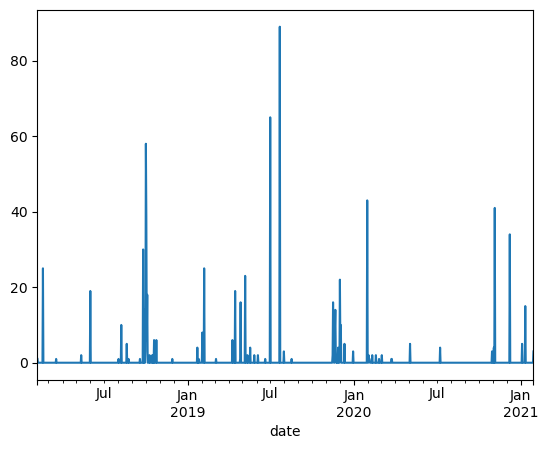

In [53]:
# plotting visual for 88
one_user_df_prep(df, 88).plot()

#### Wow! User_id #341 looked at 272 pages in a single day. Lets plot their activity:

<AxesSubplot:xlabel='date'>

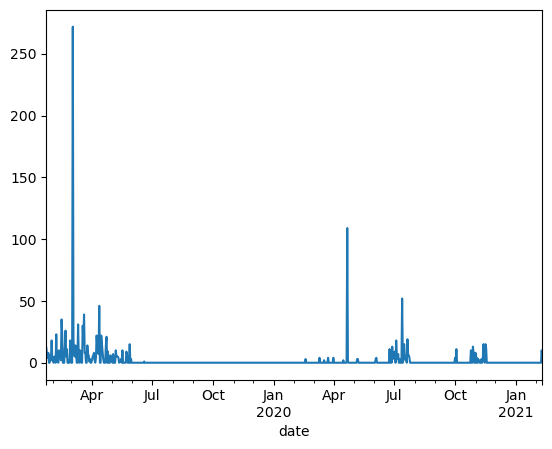

In [55]:
# plotting visual for 341
one_user_df_prep(df, 341).plot()